# Lung Disease Classification using EfficientNetB0 and PyTorch Lightning

**Abstract** <br>
This IPython Notebook will walk through how the COVID-19 Radiography X-ray images can be used to construct a Deep Learning model for classifying the type of image it is. The target categories for this are
- '*normal*': the patient's lungs were classed as healthy.
- '*afflicted*': a personal preference abbreviation for 'Lung Opacity'. This was done for a more simple one-word category.
- '*covid*': the patient was infected with COVID.
- '*pneumonia*': the patient was infected with pneumonia.

This notebook was partially inspired by https://www.kaggle.com/code/abdallahwagih/covid-19-classification-efficientnetb0-96-32, but has been adapted, and coded in PyTorch instead.
<br><br>
Moreover, this also includes using a modern framework specifically made for PyTorch called PyTorch Lightning (https://lightning.ai/docs/pytorch/stable/). This framework provides improved flexibility, scalability, and straightforwardness for using PyTorch for projects.
<br><br>
The pretrained imagery neural network EfficientNetB0 was used to improve the model through Transfer Learning principles.
<br><br>
The final constructed model had results of approx. 90% overall accuracy and approx. 0.25 Log Loss.

## Explicit dependencies

In [1]:
!pip install imbalanced-learn torch torchvision torchmetrics pytorch-lightning

## Loading the data

This section will load the images and their respective labels into a Pandas DataFrame.<br><br>
If repeating this experiment in another platform, such as Colab, when downloading the data consider using the Kaggle API (https://www.kaggle.com/docs/api) (such as shown in the figure below). It simplifies data retrieval and means no manual download and upload are required.
<br><br>
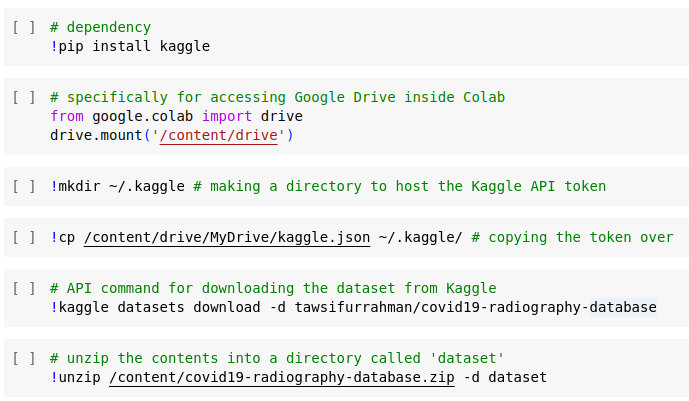

In [2]:
import pandas as pd, numpy as np, os, cv2

In [3]:
np.random.seed(42)
# for reproducibility

In [4]:
# absolute file paths are used to simply the usage of 'os.chdir()'
# masks are not needed as this notebook just concerns classification
ABS_FILE_PATHS = ['/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/',
              '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/',
              '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/',
              '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/']

In [5]:
# function for automating the retrieval and loading of image data
def retrieve_images(filepath:str):
  os.chdir(filepath)
  return [cv2.imread(img) for img in os.listdir()]

In [6]:
# combine all images retrieved into one big dataframe
df_images = pd.concat(
    [pd.DataFrame({'img': retrieve_images(ABS_FILE_PATHS[0]), 'label': 'normal'}),
     pd.DataFrame({'img': retrieve_images(ABS_FILE_PATHS[1]), 'label': 'afflicted'}),
     pd.DataFrame({'img': retrieve_images(ABS_FILE_PATHS[2]), 'label': 'covid'}),
     pd.DataFrame({'img': retrieve_images(ABS_FILE_PATHS[3]), 'label': 'pneumonia'})]
)

# change the current directory back to the main directory
os.chdir('/kaggle')

In [7]:
df_images.shape

(21165, 2)

## Exploratory Data Analysis

As this notebook concerns a classification problem and that the data is image-based, not too much EDA can be done to discover straightforward patterns and trends. The EDA that can be done is investigating the proportions of the target categories.
<br><br>
However, before this is done, to avoid train-test data leakage, the data should be split into the training and testing sets beforehand.
<br><br>
The ratio for the train\:validation\:test split will be 70:10:20 - 70\% training, 10\% validating, 20\% testing.

In [8]:
x = df_images['img']
y = df_images['label']

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=42,
                                                    test_size=0.2, stratify=y, shuffle=True)
# 'stratify' is used to enable stratified sampling, which will maintain the proportions of targets across the split
# 'random_state' is for reproducibility purposes

array([<Axes: ylabel='count'>], dtype=object)

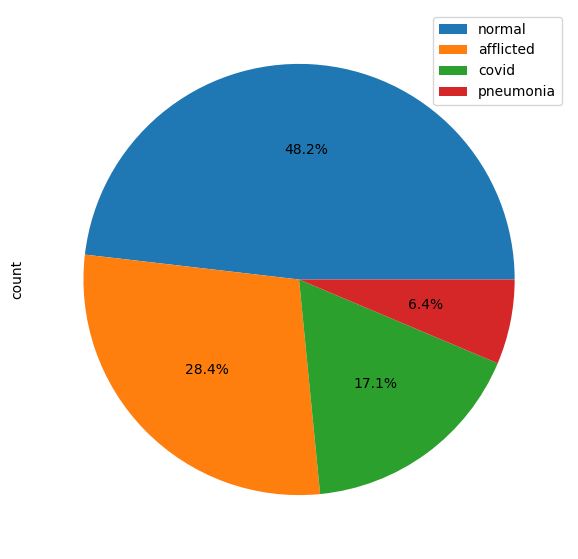

In [11]:
Y_train.value_counts().plot.pie(
    subplots=True, autopct='%1.1f%%', figsize=(7,7), fontsize=10, labeldistance=None, legend=True)

<Axes: xlabel='label'>

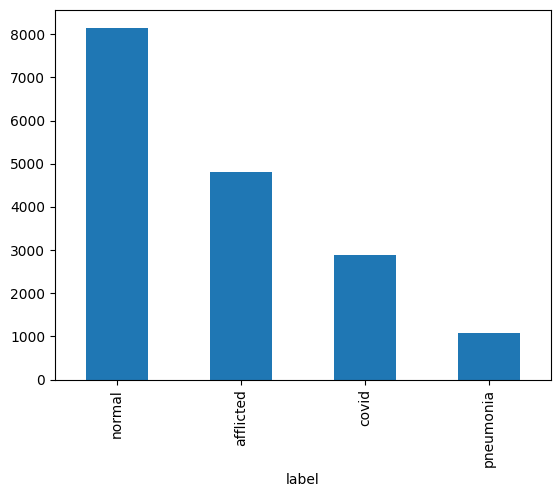

In [12]:
Y_train.value_counts().plot.bar()

As shown in the figures above, the proportions of target categories and respective imagery are not equal. Without going into in-depth detail, this can negatively impact the model as it would be more bias to identifying certain categories (the majority classes) compared to others. Although some research has indicated Deep Learning models are less suseptible to this, it still carries significance. To resolve this, during preprocessing, the proportions will be made equal using random undersampling of the majority classes - so all of the classes except 'pneumonia' (which is the minority class).

## Preprocessing

### Image resizing

Specifying the required image size for each image in the dataset. This is to make the images more consistent. This is done for both the training and testing sets.

In [13]:
IMG_SHAPE = (224, 224) #224 pixels (length) by 224 pixels (width)

In [14]:
# functions to automate the resizing of the images
def resize_imgs(images):
  for i in range(len(images)):
    images[i] = cv2.resize(images[i], IMG_SHAPE)

  return images

In [15]:
X_train = resize_imgs(X_train.values)
X_test = resize_imgs(X_test.values)
# important to note index is maintained, so no mismatch of image and class

In [16]:
for img in X_train:
  if img.shape != (224, 224, 3): # 224 length, 224 width, 3 colour channels
    print("Resizing unsuccessful.")
    
for img in X_test:
  if img.shape != (224, 224, 3): # 224 length, 224 width, 3 colour channels
    print("Resizing unsuccessful.")

### Class balancing

Random undersampling of the majority classes to balance target class proportions.

In [17]:
from imblearn.under_sampling import RandomUnderSampler

In [18]:
# converting the Pandas Series into NumPy array for compability purposes
Y_train = Y_train.to_numpy()

In [19]:
sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
# 'not minority' informs the class to resample all other (majority) classes except the minority class
# random_state is set to a constant for reproducibility purposes

In [20]:
# reshaping the data slightly so they are treated as matrices rather than vector sequences
print("The original shape of the independent variable is {}, while for the target variable it is {}.".format(
X_train.shape, X_train.shape))

X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)

print("The new shape of the independent variable is {}, while for the target variable it is {}.".format(
X_train.shape, Y_train.shape))

The original shape of the independent variable is (16932,), while for the target variable it is (16932,).
The new shape of the independent variable is (16932, 1), while for the target variable it is (16932, 1).


In [21]:
X_train_resampled, Y_train_resampled = sampler.fit_resample(X_train, Y_train)
# it is important to note, the index is not lost during this process, so there is no mix-match between images

In [22]:
print("The resampled number of images for training and validation are {} images.".format(Y_train_resampled.shape[0]))

The resampled number of images for training and validation are 4304 images.


array([<Axes: ylabel='count'>], dtype=object)

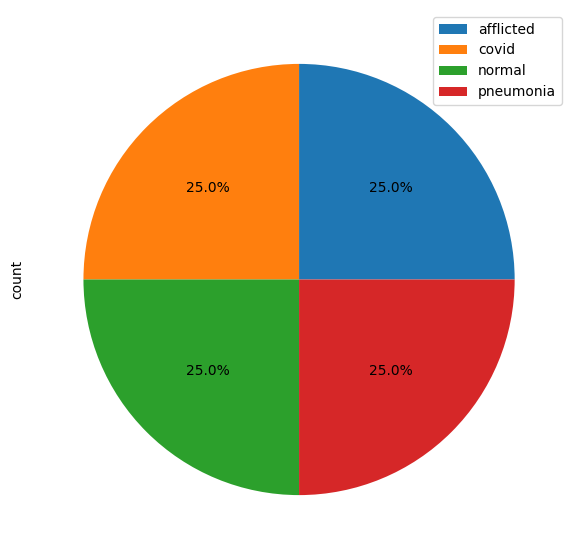

In [23]:
pd.Series(Y_train_resampled).value_counts().plot.pie(
    subplots=True, autopct='%1.1f%%', figsize=(7,7), fontsize=10, labeldistance=None, legend=True)

### Reshaping the resampled data

It is necessary to alter the shape of the images so that they meet the requirements for being passed to the model development stage. This is done for both the training and testing sets.

In [24]:
X_train_resampled.shape

(4304, 1)

In the above result, the shape of the image sequence is (5380, 1), when it should be a 4D tensor with shape (5380, 224, 224, 3) - 5380 images (can also represent batch size), with each having dimensions of 224x224 and 3 colour channels. This can be achieved using NumPy's 'concatenate' feature, which essentially removes a dimension from the data.

In [25]:
print("Original shape of image sequence: {}".format(X_train_resampled.shape))
print("Shape of image sequence after 1 concatenation: {}".format(np.concatenate(X_train_resampled).shape))
print("Shape of image sequence after 2 concatenations: {}".format(np.concatenate(np.concatenate(X_train_resampled)).shape))
# 1205120 = 5380 x 224
print("Final shape of imagery tensor after reshaping: {}".format(np.concatenate(np.concatenate(X_train_resampled)).reshape(
    X_train_resampled.shape[0], 224, 224, 3).shape))

Original shape of image sequence: (4304, 1)
Shape of image sequence after 1 concatenation: (4304,)
Shape of image sequence after 2 concatenations: (964096, 224, 3)
Final shape of imagery tensor after reshaping: (4304, 224, 224, 3)


In [26]:
X_train_resampled = np.concatenate(np.concatenate(X_train_resampled)).reshape((X_train_resampled.shape[0], 224, 224, 3))
X_test = np.concatenate(np.concatenate(X_test.reshape(-1, 1))).reshape((X_test.reshape(-1, 1).shape[0], 224, 224, 3))

### Label encoding

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
le = LabelEncoder()

In [29]:
print("Target categories before encoding: {}.".format(np.unique(Y_train_resampled)))
Y_train_resampled = le.fit_transform(Y_train_resampled)
Y_test = le.transform(Y_test)
print("Target categories after encoding: {}.".format(np.unique(Y_train_resampled)))

Target categories before encoding: ['afflicted' 'covid' 'normal' 'pneumonia'].
Target categories after encoding: [0 1 2 3].


### Train-validation split

A validation set will be created from the training set. This will enable the model to make adjustments to itself based on how well it can handle "unseen" data, without comprimising the final testing set - helping prevent train-test data leakage.

In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_resampled, Y_train_resampled, random_state=55, test_size=0.125,
                                                  stratify=Y_train_resampled, shuffle=True)

## Data preparation

In [31]:
from torch import from_numpy, stack, manual_seed, Generator
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchvision.models import efficientnet_b0
from torchmetrics.classification import Accuracy, ConfusionMatrix, F1Score, Precision, Recall

In [32]:
manual_seed(42)
# for reproducibility

In [33]:
class LungImgDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [34]:
class LungImgDataModule(pl.LightningDataModule):
  def __init__(self, X_train, X_val, X_test, Y_train, Y_val, Y_test, num_workers=0, batch_size=64):
    super().__init__()
    self.X_train = X_train
    self.X_val = X_val
    self.X_test = X_test
    self.Y_train = Y_train
    self.Y_val = Y_val
    self.Y_test = Y_test
    self.num_workers = num_workers
    self.batch_size = batch_size

  def train_dataloader(self):
    train_dataset = LungImgDataset(self.X_train, self.Y_train)
    return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True,
                      num_workers=self.num_workers)

  def val_dataloader(self):
    val_dataset = LungImgDataset(self.X_val, self.Y_val)
    return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False,
                      num_workers=self.num_workers)

  def test_dataloader(self):
    test_dataset = LungImgDataset(self.X_test, self.Y_test)
    return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False,
                      num_workers=self.num_workers)

In [35]:
# converting the split data from NumPy arrays to PyTorch Tensors
X_train_tensor = from_numpy(X_train)
X_val_tensor = from_numpy(X_val)
X_test_tensor = from_numpy(X_test)
Y_train_tensor = from_numpy(Y_train)
Y_val_tensor = from_numpy(Y_val)
Y_test_tensor = from_numpy(Y_test)

To make the transformed tensors compatible with the pretrained neural network, it is necessary to rearrange the context of the data slightly to suit what is expected (as shown below). The current shape of the data should be (5380, 224, 224, 3), but the expected input shape for the pretrained network is (batch_size, colour channels, length, width), which would mean the shape of the data needs to be (5380, 3, 224, 224).

In [36]:
print("The shape of X_train_tensor before permutation: {}".format(X_train_tensor.shape))
X_train_tensor_permutated = X_train_tensor.permute(0, 3, 1, 2)
X_val_tensor_permutated = X_val_tensor.permute(0, 3, 1, 2)
X_test_tensor_permutated = X_test_tensor.permute(0, 3, 1, 2)
print("The shape of X_train_tensor after permutation: {}".format(X_train_tensor_permutated.shape))
print("The shape of X_test_tensor after permutation: {}".format(X_test_tensor_permutated.shape))

The shape of X_train_tensor before permutation: torch.Size([3766, 224, 224, 3])
The shape of X_train_tensor after permutation: torch.Size([3766, 3, 224, 224])
The shape of X_test_tensor after permutation: torch.Size([4233, 3, 224, 224])


In [37]:
data_module = LungImgDataModule(X_train=X_train_tensor_permutated.float(), X_val=X_val_tensor_permutated.float(),
                                X_test=X_test_tensor_permutated.float(),
                                Y_train=Y_train_tensor, Y_val=Y_val_tensor, Y_test=Y_test_tensor)
# the Tensors are converted from integer types to float types, otherwise leads to an error
# 'num_workers' can only be used if a GPU is available
    # if it causes issues, don't pass any arguments to it

## Base model development (Transfer Learning - shallow mode)

The base model is very useful for comparison purposes for when making adjustments to the model's performance. It is important to note when doing this, the base model should not be compared to the test set as this would lead to train-test data leakage - as improvements would be made using insights gained from comparing the base model to the testing set.

In [38]:
class BaseModelLightning(pl.LightningModule):
  def __init__(self, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss(), num_classes=4, learning_rate=1e-3):
    super().__init__()
    self.conv_model = efficientnet_b0(weights='IMAGENET1K_V1') # pretrained neural network
    
    # shallow mode - freeze the learnable parameters of all the layers of the network
    for params in self.conv_model.parameters():
      params.requires_grad = False

    # changing the classifier layer to suit the number of outputs for classification
    # this unfreezes the learnable parameters for the classifier layer
    self.conv_model.classifier[1] = nn.Linear(in_features=self.conv_model.classifier[1].in_features,
                                              out_features=num_classes)

    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.criterion = criterion

    # evaluation metrics
    self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    
    self.train_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    self.val_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    self.test_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    
    self.train_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.val_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.test_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    
    self.train_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
    self.val_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
    self.test_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')

    # for plotting the learning curves
    self.train_step_losses=[]
    self.val_step_losses=[]
    self.train_step_accs=[]
    self.val_step_accs=[]

    self.train_losses=[]
    self.val_losses=[]
    self.train_accs=[]
    self.val_accs=[]

  def forward(self, x):
    return self.conv_model(x)

  def training_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.train_accuracy(Y_hat, Y)
    f1score = self.train_f1score(Y_hat, Y)
    precision = self.train_precision(Y_hat, Y)
    recall = self.train_recall(Y_hat, Y)
    self.train_step_losses.append(loss)
    self.train_step_accs.append(acc)
    self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
    self.log('train_precision', precision, on_step=False, on_epoch=True)
    self.log('train_recall', recall, on_step=False, on_epoch=True)
    self.log('train_loss', loss, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.val_accuracy(Y_hat, Y)
    f1score = self.val_f1score(Y_hat, Y)
    precision = self.val_precision(Y_hat, Y)
    recall = self.val_recall(Y_hat, Y)
    self.val_step_losses.append(loss)
    self.val_step_accs.append(acc)
    self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log('val_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
    self.log('val_precision', precision, on_step=False, on_epoch=True)
    self.log('val_recall', recall, on_step=False, on_epoch=True)
    self.log('val_loss', loss, on_epoch=True)
    return loss

  def on_train_epoch_end(self):
    # for plotting the training learning curve
    avg_loss = stack(self.train_step_losses).mean().item()
    avg_acc = stack(self.train_step_accs).mean().item()
    self.train_losses.append(avg_loss)
    self.train_accs.append(avg_acc)
    self.train_step_losses.clear()
    self.train_step_accs.clear()

  def on_validation_epoch_end(self):
    # for plotting the validation learning curve
    avg_loss = stack(self.val_step_losses).mean().item()
    avg_acc = stack(self.val_step_accs).mean().item()
    self.val_losses.append(avg_loss)
    self.val_accs.append(avg_acc)
    self.val_step_losses.clear()
    self.val_step_accs.clear()

  def test_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.test_accuracy(Y_hat, Y)
    f1score = self.test_f1score(Y_hat, Y)
    precision = self.test_precision(Y_hat, Y)
    recall = self.test_recall(Y_hat, Y)
    self.log('test_acc', acc, on_step=False, on_epoch=True)
    self.log('test_f1score', f1score, on_step=False, on_epoch=True)
    self.log('test_precision', precision, on_step=False, on_epoch=True)
    self.log('test_recall', recall, on_step=False, on_epoch=True)
    self.log('test_loss', loss, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [39]:
base_model = BaseModelLightning()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s]


In [40]:
base_trainer = pl.Trainer(max_epochs=11)
base_trainer.fit(base_model, data_module)

2024-08-30 16:21:15.806164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 16:21:15.806283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 16:21:15.946137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Base model evaluation

### Learning curves

In [41]:
import matplotlib.pyplot as plt

def plot_metrics(model):
    epochs = range(len(model.train_losses))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.train_losses, label='Train Loss')
    plt.plot(epochs, model.val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.train_accs, label='Train Accuracy')
    plt.plot(epochs, model.val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [42]:
# removing first entries of the validation logs as these are not relevant to the learning curves
del base_model.val_losses[0]
del base_model.val_accs[0]

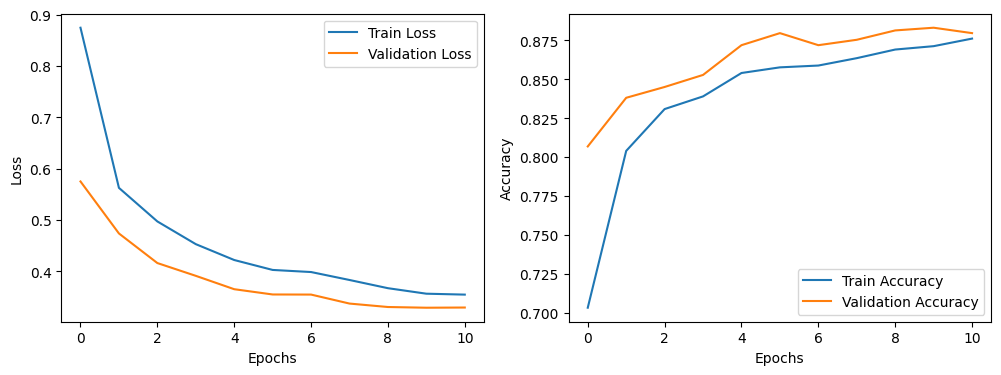

In [43]:
plot_metrics(base_model)

**Analysis** <br>
Based on the learning curves, it appears the model has underfitted to the available data. There are numerous ways to help tackle underfitting, but the 2 methods that will be leveraged here will be an increased learning rate and utilising fine-tuning. The increased learning rate will better enable the model to find the global minimum gradient, while the fine-tuning process will aid this by allowing higher level layers to adapt their learnable parameters. Model development is an iterative process where several methods and parameters should be tried to help achieve better model results.

## Improved model development (Transfer Learning - fine-tuning mode)

In [44]:
class FinalModelLightning(pl.LightningModule):
  def __init__(self, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss(), num_classes=4, learning_rate=1e-3):
    super().__init__()
    self.conv_model = efficientnet_b0(weights='IMAGENET1K_V1') # pretrained neural network
    
    # shallow mode - freeze the learnable parameters of all the layers of the network
    for params in self.conv_model.parameters():
      params.requires_grad = False

    # fine-tuning - unfreeze some of the higher level (last) feature layers of the network to enable more refined
        # image analysis
    # this does not include the classifier layer
    for param in self.conv_model.features[-2:].parameters():
      param.requires_grad = True

    # changing the classifier layer to suit the number of outputs for classification
    self.conv_model.classifier[1] = nn.Linear(in_features=self.conv_model.classifier[1].in_features,
                                              out_features=num_classes)

    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.criterion = criterion

    # evaluation metrics
    self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
    
    self.train_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    self.val_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    self.test_f1score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    
    self.train_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.val_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.test_precision = Precision(task='multiclass', num_classes=num_classes, average='macro')
    
    self.train_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
    self.val_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')
    self.test_recall = Recall(task='multiclass', num_classes=num_classes, average='macro')

    # for plotting the learning curves
    self.train_step_losses=[]
    self.val_step_losses=[]
    self.train_step_accs=[]
    self.val_step_accs=[]

    self.train_losses=[]
    self.val_losses=[]
    self.train_accs=[]
    self.val_accs=[]

  def forward(self, x):
    return self.conv_model(x)

  def training_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.train_accuracy(Y_hat, Y)
    f1score = self.train_f1score(Y_hat, Y)
    precision = self.train_precision(Y_hat, Y)
    recall = self.train_recall(Y_hat, Y)
    self.train_step_losses.append(loss)
    self.train_step_accs.append(acc)
    self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
    self.log('train_precision', precision, on_step=False, on_epoch=True)
    self.log('train_recall', recall, on_step=False, on_epoch=True)
    self.log('train_loss', loss, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.val_accuracy(Y_hat, Y)
    f1score = self.val_f1score(Y_hat, Y)
    precision = self.val_precision(Y_hat, Y)
    recall = self.val_recall(Y_hat, Y)
    self.val_step_losses.append(loss)
    self.val_step_accs.append(acc)
    self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
    self.log('val_f1score', f1score, on_step=False, on_epoch=True, prog_bar=True)
    self.log('val_precision', precision, on_step=False, on_epoch=True)
    self.log('val_recall', recall, on_step=False, on_epoch=True)
    self.log('val_loss', loss, on_epoch=True)
    return loss

  def on_train_epoch_end(self):
    # for plotting the training learning curve
    avg_loss = stack(self.train_step_losses).mean().item()
    avg_acc = stack(self.train_step_accs).mean().item()
    self.train_losses.append(avg_loss)
    self.train_accs.append(avg_acc)
    self.train_step_losses.clear()
    self.train_step_accs.clear()

  def on_validation_epoch_end(self):
    # for plotting the validation learning curve
    avg_loss = stack(self.val_step_losses).mean().item()
    avg_acc = stack(self.val_step_accs).mean().item()
    self.val_losses.append(avg_loss)
    self.val_accs.append(avg_acc)
    self.val_step_losses.clear()
    self.val_step_accs.clear()

  def test_step(self, batch, batch_idx):
    X, Y = batch
    Y_hat = self.conv_model(X)
    loss = self.criterion(Y_hat, Y)
    acc = self.test_accuracy(Y_hat, Y)
    f1score = self.test_f1score(Y_hat, Y)
    precision = self.test_precision(Y_hat, Y)
    recall = self.test_recall(Y_hat, Y)
    self.log('test_acc', acc, on_step=False, on_epoch=True)
    self.log('test_f1score', f1score, on_step=False, on_epoch=True)
    self.log('test_precision', precision, on_step=False, on_epoch=True)
    self.log('test_recall', recall, on_step=False, on_epoch=True)
    self.log('test_loss', loss, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [45]:
final_model = FinalModelLightning(learning_rate=1e-4)

In [46]:
final_trainer = pl.Trainer(max_epochs=11)
final_trainer.fit(final_model, data_module)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Final model evaluation

In [47]:
# removing first entries of the validation logs as these are not relevant to the learning curves
del final_model.val_losses[0]
del final_model.val_accs[0]

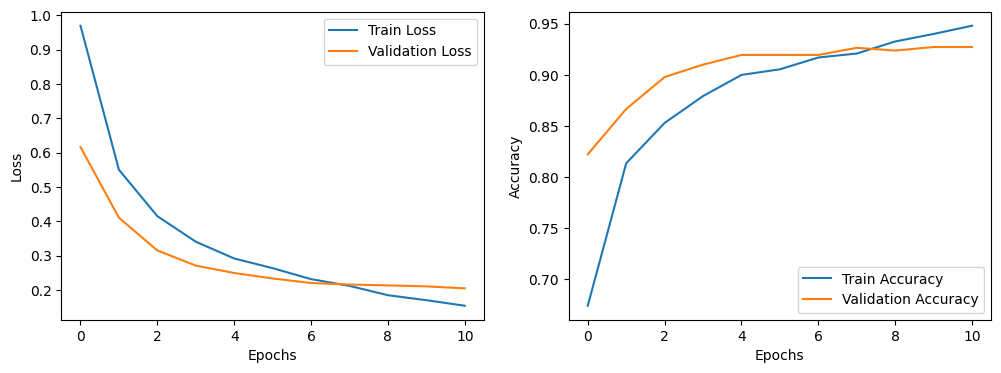

In [48]:
plot_metrics(final_model)

**Analysis**<br>
Thanks to the improved approach, based on the learning curves, the final model no longer underfits to the data, but now slightly overfits instead. There are several techniques that can be used to tackle overfitting, such as increasing dropout, data augmentation, regularisation, batch normalisation, etc., but these will not be implemented in this notebook.<br><br>
For demonstration purposes, the final base model testing results will be shown alongside the improved model testing results.

In [49]:
base_trainer.test(base_model, data_module)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8518781065940857     │
│       test_f1score        │    0.8398824334144592     │
│         test_loss         │    0.39259234070777893    │
│      test_precision       │     0.828803300857544     │
│        test_recall        │    0.8724270462989807     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8518781065940857,
  'test_f1score': 0.8398824334144592,
  'test_precision': 0.828803300857544,
  'test_recall': 0.8724270462989807,
  'test_loss': 0.39259234070777893}]

In [50]:
final_trainer.test(final_model, data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8899126052856445     │
│       test_f1score        │    0.8891525268554688     │
│         test_loss         │    0.3007636070251465     │
│      test_precision       │    0.8762226700782776     │
│        test_recall        │    0.9153614044189453     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8899126052856445,
  'test_f1score': 0.8891525268554688,
  'test_precision': 0.8762226700782776,
  'test_recall': 0.9153614044189453,
  'test_loss': 0.3007636070251465}]